# XGboost Classifier - Baseline Model

In [19]:
#Importing the libraries
import numpy as np
import pandas as pd


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE

import xgboost as xgb  # Load this xgboost

from sklearn.model_selection import train_test_split


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split

## Step 1 - Loading Dataset

In [20]:
#Importing  the Dataset

attrition = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [21]:
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [22]:
attrition.shape

(1470, 35)

In [23]:
attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [24]:
attrition.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [25]:
attrition.describe(include='O')

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


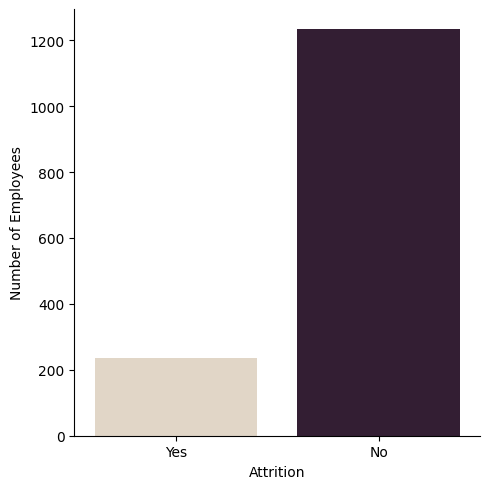

In [26]:
#Checking the number of 'Yes' and 'No' in 'Attrition'
ax = sns.catplot(x="Attrition", kind="count", palette="ch:.25", data=attrition);
ax.set(xlabel = 'Attrition', ylabel = 'Number of Employees')
plt.show()

In [27]:
#Identifying columns with missing information
missing_col = attrition.columns[attrition.isnull().any()].values
print('The missing columns in the dataset are: ',missing_col)

The missing columns in the dataset are:  []


In [28]:
attrition.isnull().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


# Feature Engineering & Categorical Encoding

In [29]:
attrition.dtypes

,0
Age,int64
Attrition,object
BusinessTravel,object
DailyRate,int64
Department,object
DistanceFromHome,int64
Education,int64
EducationField,object
EmployeeCount,int64
EmployeeNumber,int64


In [30]:
#Extracting the Numeric and Categorical features

attrition_num = pd.DataFrame(data = attrition.select_dtypes(include = ['int64']))
attrition_cat = pd.DataFrame(data = attrition.select_dtypes(include = ['object']))
print("Shape of Numeric: ",attrition_num.shape)
print("Shape of Categorical: ",attrition_cat.shape)

Shape of Numeric:  (1470, 26)
Shape of Categorical:  (1470, 9)


In [31]:
attrition_num.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [32]:
attrition_cat.columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [33]:
# drop the dependent column from the categorical frame

attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column

In [34]:
attrition_cat.head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


### Encoding Categorical Fields

The categorical fields have been encoded using the get_dummies() function of Pandas.

In [35]:

#Encoding using Pandas' get_dummies
attrition_cat_encoded = pd.get_dummies(attrition_cat , dtype=int)
attrition_cat_encoded.head(5)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1
3,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
4,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0


In [36]:

print("Shape of Numeric columns after scaling :" , attrition_num.shape)
print("Shape of Categorical columns after scaling :" , attrition_cat_encoded.shape)

Shape of Numeric columns after scaling : (1470, 26)
Shape of Categorical columns after scaling : (1470, 29)


In [37]:
#Combining the Categorical and Numeric features

attrition_final_df = pd.concat([attrition_num,attrition_cat_encoded], axis = 1)
print("Shape of final dataframe: ",attrition_final_df.shape)

Shape of final dataframe:  (1470, 55)


In [38]:
attrition_final_df.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1102,1,2,1,1,2,94,3,2,4,5993,19479,8,11,3,1,80,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,49,279,8,1,1,2,3,61,2,2,2,5130,24907,1,23,4,4,80,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,37,1373,2,2,1,4,4,92,2,1,3,2090,2396,6,15,3,2,80,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1
3,33,1392,3,4,1,5,4,56,3,1,3,2909,23159,1,11,3,3,80,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
4,27,591,2,1,1,7,1,40,3,1,2,3468,16632,9,12,3,4,80,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0


In [39]:
#Extracting the target variable - 'Attrition'
target = attrition['Attrition']

#Mapping 'Yes' to 1 and 'No' to 0
map = {'Yes':1, 'No':0}
target = target.apply(lambda x: map[x])

print("Shape of target: ",target.shape)

X = attrition_final_df #Features
y = target #Target

Shape of target:  (1470,)


### Train and Test Split

The data is next split into training and test dataset using the train_test_split functionality of sklearn.

In [40]:

# Split data into train and test sets as well as for validation and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.75,random_state=0);
print("Shape of X Train: ",X_train.shape)
print("Shape of X Test: ",X_test.shape)
print("Shape of y Train: ",y_train.shape)
print("Shape of y Test: ",y_test.shape)

Shape of X Train:  (1102, 55)
Shape of X Test:  (368, 55)
Shape of y Train:  (1102,)
Shape of y Test:  (368,)


# Step 3 - Model Fitting

## Xgboost Classifier

1.n_estimators - No of Trees in the Model

2.max_leaf_nodes = The maximum number of terminal nodes or leaves in a tree. If this is defined, max_depth will be ignored

3.min_child_weight - Defines the minimum sum of weights of all observations required in a child.

4.max_depth - Maximum Depth of Tree and can be used to control overfiting

5.subsample- The fraction of samples to be used for fitting the individual base learners

6.learning_rate - Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators
Regularization parameters

7. gamma - A node is split only when the resulting split gives a postive Gain. Gamma specifies the minimum loss reduction required to make a split.

8. lambda - This used to handle the regularization part of XGBoost. It should be explored to reduce overfitting

Imbalanced Data Handling
9. scale_pos_weight - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence

In [41]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
# Fit the model to our train and target

xgb_cfl.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
# Get our predictions

xgb_predictions = xgb_cfl.predict(X_test)

In [44]:
xgb_predictions_prob = xgb_cfl.predict_proba(X_test)
xgb_predictions_prob

array([[9.80802476e-01, 1.91975068e-02],
       [9.99925792e-01, 7.42326592e-05],
       [9.68313873e-01, 3.16861533e-02],
       [9.69120681e-01, 3.08792982e-02],
       [4.23973799e-03, 9.95760262e-01],
       [6.50538146e-01, 3.49461854e-01],
       [7.71121085e-01, 2.28878915e-01],
       [9.77243125e-01, 2.27568597e-02],
       [9.96759653e-01, 3.24033108e-03],
       [9.28561509e-01, 7.14384764e-02],
       [9.99308348e-01, 6.91627502e-04],
       [9.75794256e-01, 2.42057461e-02],
       [9.99040246e-01, 9.59759229e-04],
       [7.03077316e-02, 9.29692268e-01],
       [9.99101222e-01, 8.98779952e-04],
       [9.99957383e-01, 4.25999897e-05],
       [9.95473862e-01, 4.52613644e-03],
       [9.99491930e-01, 5.08057943e-04],
       [9.75677967e-01, 2.43220292e-02],
       [9.87874329e-01, 1.21256514e-02],
       [8.60899210e-01, 1.39100775e-01],
       [9.94047403e-01, 5.95258083e-03],
       [9.99224126e-01, 7.75870751e-04],
       [9.99883235e-01, 1.16776842e-04],
       [5.050388

In [45]:
xgb_predictions_prob.shape

(368, 2)

In [46]:
accuracy_score(y_test, xgb_predictions)

0.8695652173913043

# HPT (Hyperparameter optimization)- Random Search

In [47]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5

param_comb = 800

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)

In [48]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 5],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 10, 12],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 750],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=3)

In [49]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

 Best accuracy for 5-fold search with 800 parameter combinations:
0.8793171534348005

 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.02, 'gamma': 0.1, 'colsam

In [50]:
xgb_predictions_hpt = random_search.predict(X_test)
accuracy_score(y_test, xgb_predictions_hpt)

0.8831521739130435

### Feature Importance XGboost Model

In [51]:
xgb_cfl.feature_importances_

array([0.02663871, 0.01600106, 0.01433308, 0.01167052, 0.        ,
       0.01372479, 0.02261208, 0.01608823, 0.02286761, 0.0503764 ,
       0.02042658, 0.02043496, 0.01375093, 0.02660762, 0.01451358,
       0.        , 0.01975274, 0.        , 0.02983482, 0.01363983,
       0.01295772, 0.01620325, 0.0169708 , 0.01497729, 0.01723427,
       0.04283749, 0.00261417, 0.03125522, 0.05138135, 0.        ,
       0.01664683, 0.01017353, 0.        , 0.01151736, 0.01584176,
       0.01469793, 0.        , 0.01378211, 0.01465011, 0.        ,
       0.        , 0.        , 0.0163368 , 0.03206247, 0.0894463 ,
       0.        , 0.01567406, 0.03245819, 0.01162295, 0.02320496,
       0.01343417, 0.0640484 , 0.        , 0.04469697, 0.        ],
      dtype=float32)

In [52]:
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display
import pandas as pd # Make sure pandas is imported

# Assuming gb and attrition_final_df are already defined

# Scatter plot

pio.renderers.default = 'colab'  # Force Colab renderer (optional, but recommended)

trace = go.Scatter(
    y = xgb_cfl.feature_importances_,
    x = attrition_final_df.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1.3,
        size = 12,
        color = xgb_cfl.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final_df.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'XGBM Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
display(fig)

# SHAP explainability

In [53]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import shap

In [55]:
%time explainer = shap.explainers.Tree(xgb_cfl, data=X_test)

CPU times: user 63.8 ms, sys: 1.4 ms, total: 65.2 ms
Wall time: 67.9 ms


In [56]:
%time shap_values = explainer(X_test)

CPU times: user 2.22 s, sys: 0 ns, total: 2.22 s
Wall time: 2.53 s


In [57]:
shap_values

.values =
array([[-0.58675281, -0.10336425,  0.24152955, ...,  0.        ,
        -0.77331413,  0.        ],
       [-0.15084683, -0.04703789,  0.51886348, ...,  0.        ,
        -0.82624704,  0.        ],
       [-0.4006563 ,  0.3137867 ,  0.59029678, ...,  0.        ,
         1.87597185,  0.        ],
       ...,
       [-0.66272269, -0.0191291 ,  0.12310186, ...,  0.        ,
         1.54786949,  0.        ],
       [ 0.14355744, -0.24876214, -0.23696841, ...,  0.        ,
        -0.46610614,  0.        ],
       [ 0.17664886,  0.09007462,  1.04233114, ...,  0.        ,
         1.75855431,  0.        ]])

.base_values =
array([-3.98389526, -3.98389526, -3.98389526, -3.98389526, -3.98389526,
       -3.98389526, -3.98389526, -3.98389526, -3.98389526, -3.98389526,
       -3.98389526, -3.98389526, -3.98389526, -3.98389526, -3.98389526,
       -3.98389526, -3.98389526, -3.98389526, -3.98389526, -3.98389526,
       -3.98389526, -3.98389526, -3.98389526, -3.98389526, -3.98389526,
 

In [58]:
shap_values.values.shape

(368, 55)

In [71]:
shap_values.values[0]

array([-5.86752805e-01, -1.03364247e-01,  2.41529550e-01,  8.37636165e-02,
        0.00000000e+00, -2.17558659e-01, -3.91502357e-01, -1.15172677e-01,
       -8.14994964e-02,  5.25803636e-01, -3.06005436e-01,  1.63823715e-01,
        1.90501882e-02, -3.70108938e-01, -1.60723219e-01,  0.00000000e+00,
       -1.58396476e-01,  0.00000000e+00,  3.35239383e-01, -6.43611328e-02,
       -3.48993274e-02,  2.26475539e-01,  4.37912250e-01, -5.20135453e-02,
        8.79084941e-01,  1.33206393e-01, -2.15353303e-01, -1.27037444e-01,
        1.60911102e-01,  0.00000000e+00,  1.50597538e-01,  6.16960563e-02,
        0.00000000e+00,  6.51672413e-02,  4.93631470e-03, -9.34593263e-02,
        0.00000000e+00, -2.54598522e-02,  5.92553630e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.01905316e-01, -5.19280452e-04,
        0.00000000e+00,  0.00000000e+00,  1.45798773e-03,  2.68152540e-01,
       -1.93165315e-02,  1.21845145e-01, -1.76387491e-01,  2.85508632e-01,
        0.00000000e+00, -

In [73]:
shap_values.base_values.shape

(368,)

In [76]:
shap_values.data[0]

array([   36,   635,    10,     4,     1,   592,     2,    32,     3,
           3,     4,  9980, 15318,     1,    14,     3,     4,    80,
           0,    10,     3,     2,    10,     3,     9,     7,     1,
           0,     0,     0,     0,     1,     0,     0,     0,     1,
           0,     0,     0,     1,     0,     0,     0,     0,     0,
           0,     0,     1,     0,     0,     0,     1,     1,     1,
           0])

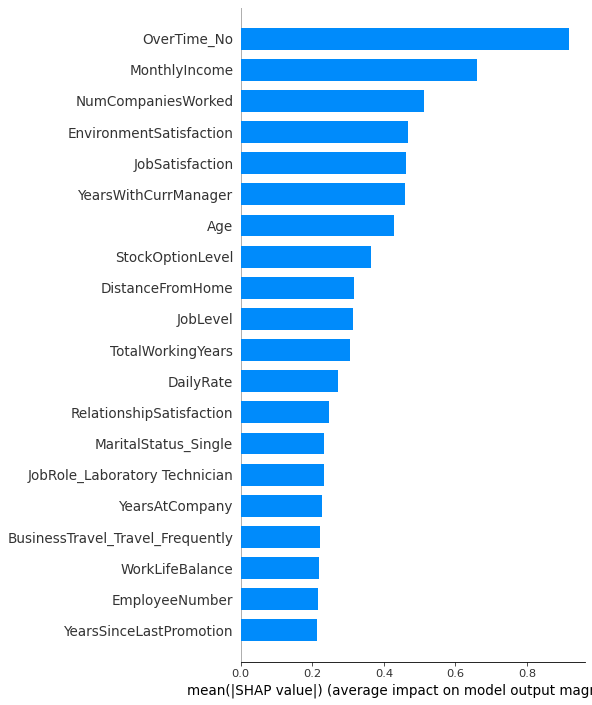

CPU times: user 431 ms, sys: 174 ms, total: 605 ms
Wall time: 511 ms


In [59]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_test , plot_type='bar')

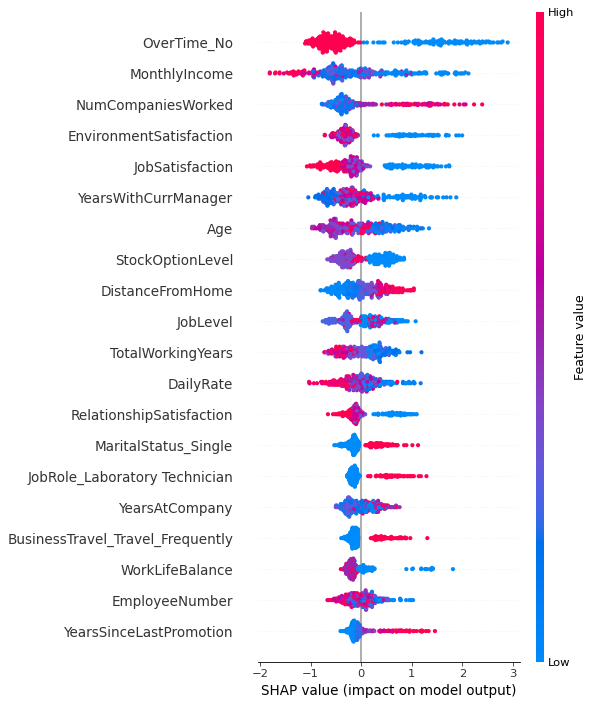

CPU times: user 1.11 s, sys: 347 ms, total: 1.46 s
Wall time: 1.96 s


In [60]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_test)

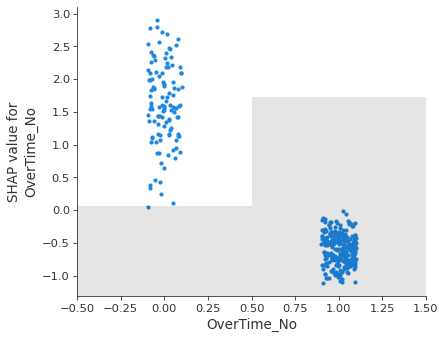

In [62]:
shap.plots.scatter(shap_values[:,'OverTime_No'])

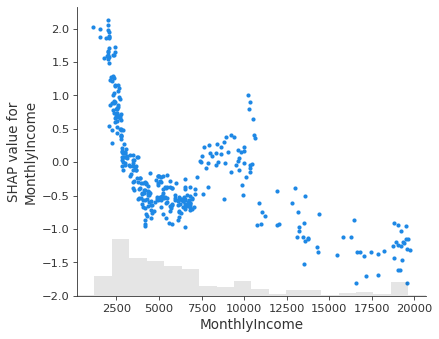

In [63]:
shap.plots.scatter(shap_values[:,'MonthlyIncome'])

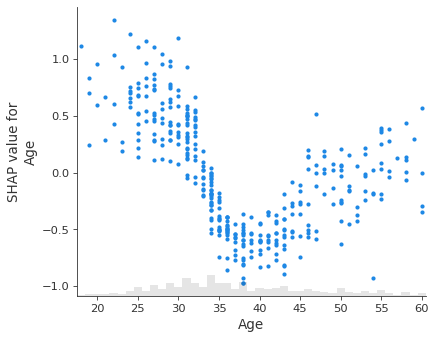

In [64]:
shap.plots.scatter(shap_values[:,'Age'])

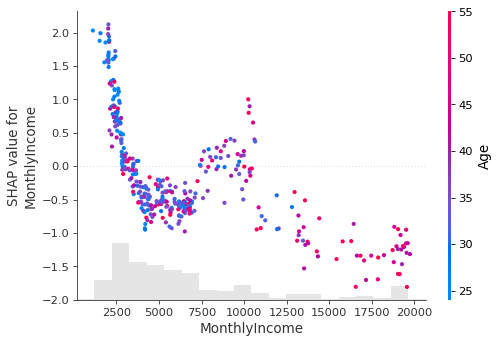

In [65]:
shap.plots.scatter(shap_values[:,'MonthlyIncome'],
                   color=shap_values[:,'Age'])